# The quantitative accuracy evaluation of VO/VIO/SLAM
First, the estimated trajectory needs to be aligned with the groundtruth.
Then, the trajectory estimation error can be calculated from the aligned estimate and the groundtruth using certain error metrics (i.e., absolute trajectory error and relative error).

In this file, we demonstrate how to calculate these evaluation metrics and visualize the results using [evo](https://github.com/MichaelGrupp/evo) in python code.
* More details of command line interface can be seen in [Our Github Repository](https://github.com/arclab-hku/Event_based_VO-VIO-SLAM/issues/5)
* While more details of the quantitative evaluation of pose tracking can be seen in [our paper](), and [rpg_trajectory_evaluation](https://www.zora.uzh.ch/id/eprint/175991/1/IROS18_Zhang.pdf).
* You need to install the evo package before running the code.
~~~
 pip install evo
~~~

## Tips on using this ipynb
* Setup the conda environment following [Link](https://github.com/KwanWaiPang/ESIM_comment), and select the kernel as vid2e; When using the Server, you can run the following command to speed up the process:
~~~
conda activate vid2e
pip install ipykernel
~~~
* Download the sampled dataset
~~~
conda activate nerf-ngp
bypy list
bypy download [remotepath] [localpath]
~~~

In [1]:
import numpy as np
import multiprocessing #多线程处理
import cv2
import matplotlib.pyplot as plt #绘图


import rosbag #处理rosbag
from cv_bridge import CvBridge

import sys
sys.path.append('/home/gwp/Poster_files/trajectory_evaluation')  # add the path of the utils, please note that when you change the code, the kernel should be restarted
from utils.bag_utils import read_H_W_from_bag, read_tss_us_from_rosbag, read_images_from_rosbag, read_evs_from_rosbag, read_calib_from_bag, read_t0us_evs_from_rosbag, read_poses_from_rosbag
print("import ultils to process the rosbag")

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


import ultils to process the rosbag


In [2]:
rosbag_file="../dataset/ESVIO_hku_agg_small_flip.bag"
# read data from rosbag
bag_data = rosbag.Bag(rosbag_file, "r")
topics = list(bag_data.get_type_and_topic_info()[1].keys())
print("all the topic name in this rosbag",topics)

all the topic name in this rosbag ['/cpy_uav/viconros/odometry', '/pose_graph/evio_odometry']


In [3]:
gt_topic_name='/cpy_uav/viconros/odometry';
est_topic_name='/pose_graph/evio_odometry';
gt_poses, tss_gt_us =read_poses_from_rosbag(bag_data,gt_topic_name)
assert np.all(tss_gt_us == sorted(tss_gt_us)) 
est_poses, tss_est_us =read_poses_from_rosbag(bag_data,est_topic_name)
assert np.all(tss_est_us == sorted(tss_est_us)) #assert that the timestamps are sorted

100%|██████████| 59060/59060 [00:02<00:00, 19713.30it/s]


In [24]:
# define several useful functions
import evo
import evo.main_ape as main_ape
from evo.core import sync, metrics
from evo.core.trajectory import PoseTrajectory3D
from evo.core.metrics import PoseRelation

# def ate(traj_ref, traj_est, timestamps):
#     traj_est = PoseTrajectory3D(
#         positions_xyz=traj_est[:,:3],
#         orientations_quat_wxyz=traj_est[:,3:], # TODO EVO uses wxyz, we use xyzw
#         timestamps=timestamps)

#     traj_ref = PoseTrajectory3D(
#         positions_xyz=traj_ref[:,:3],
#         orientations_quat_wxyz=traj_ref[:,3:],  # TODO EVO uses wxyz, we use xyzw
#         timestamps=timestamps)
    
#     result = main_ape.ape(traj_ref, traj_est, est_name='traj', 
#         pose_relation=PoseRelation.translation_part, align=True, correct_scale=True)

#     return result.stats["rmse"]

def ate_translation(traj_ref, tss_ref_us, traj_est, tstamps):

        # obtain the data structure of pose+timestamp
        # please refer to:https://github.com/MichaelGrupp/evo/blob/63ea6f087bf6aca9e9feef193c605b0489cca4cd/evo/core/trajectory.py#L372
        evoGT = PoseTrajectory3D(
                positions_xyz=traj_ref[:,:3],
                orientations_quat_wxyz=traj_ref[:,3:], # EVO uses wxyz
                timestamps=(np.array(tss_ref_us)/1e6))

        # get the ground truth trajectory length
        gtlentraj = evoGT.get_infos()["path length (m)"]

        evoEst = PoseTrajectory3D(
                positions_xyz=traj_est[:,:3],#translation part
                orientations_quat_wxyz=traj_est[:,3:], # EVO uses wxyz
                timestamps=np.array(tstamps)/1e6)#change the unit from us to s

        # if the size of the two trajectories are the same, we can directly calculate the ATE
        # if traj_ref.shape == traj_est.shape:
        #         assert np.all(tss_ref_us == tstamps)
        #         return ate(traj_ref, traj_est, tstamps)*100, evoGT, evoEst

        # The metrics require the trajectories to be associated via matching timestamps:
        # please refer to:https://github.com/MichaelGrupp/evo/blob/63ea6f087bf6aca9e9feef193c605b0489cca4cd/evo/core/sync.py#L67
        evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
        # （absolute pose error ）
        ape_trans = main_ape.ape(evoGT, evoEst, pose_relation=metrics.PoseRelation.translation_part, align=True, correct_scale=True)
        # get the rmse value，and then multiply 100 to get the cm
        evoATE = ape_trans.stats["rmse"]
        MPE = ape_trans.stats["mean"] / gtlentraj * 100 # mean pose error of our EVIO
        return evoATE, MPE, evoGT, evoEst


ATE / rmse[m]: 0.169 | MPE[%/m]: 0.351
<class 'numpy.ndarray'>


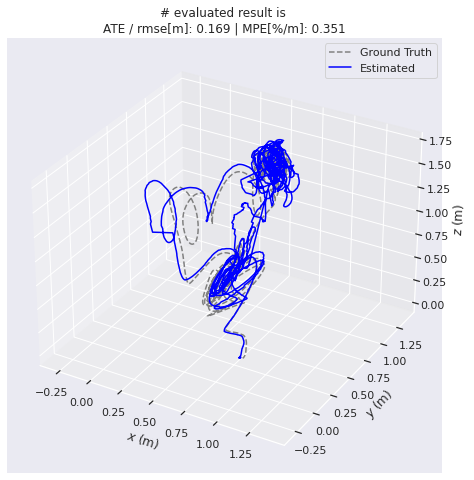

In [25]:
ate_score, MPE, evoGT, evoEst = ate_translation(gt_poses, tss_gt_us, est_poses, tss_est_us)
res_str = f"\nATE / rmse[m]: {ate_score:.03f} | MPE[%/m]: {MPE:.03f}"
print(res_str)
print(type(evoGT.positions_xyz))

from evo.tools import plot
# for the sever useer, we need to set the backend from "TkAgg" to "Agg"
from evo.tools.settings import SETTINGS
SETTINGS['plot_backend'] = 'Agg'
plot.apply_settings(SETTINGS)

from evo.core.geometry import GeometryException

def plot_trajectory(pred_traj, gt_traj, title="", filename="", align=True, correct_scale=True, max_diff_sec=0.01):
    if align:
        try:
            pred_traj.align(gt_traj, correct_scale=correct_scale)
        except GeometryException as e:
            print("Plotting error:", e)
    # print(len(pred_traj.positions_xyz), len(gt_traj.positions_xyz))
    plot_mode = plot.PlotMode.xyz
    fig = plt.figure(figsize=(8, 8))
    ax = plot.prepare_axis(fig, plot_mode)
    ax.set_title(title)
    plot.traj(ax, plot_mode, gt_traj, '--', 'gray', "Ground Truth")
    plot.traj(ax, plot_mode, pred_traj, '-', 'blue', "Estimated")
    ax.legend()
    # plt.savefig("../dataset/result.png")
    plt.show()

%matplotlib inline
plot_trajectory(evoEst, evoGT,f"# evaluated result is {res_str}")


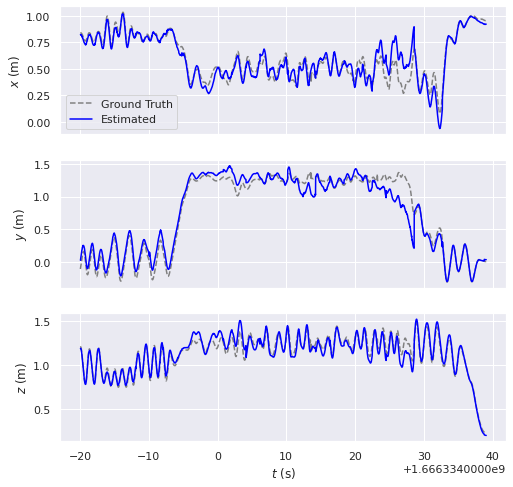

In [26]:
def plot_trajectory_xyz(pred_traj, gt_traj, title="", filename="", align=True, correct_scale=True, max_diff_sec=0.01):
    if align:
        try:
            pred_traj.align(gt_traj, correct_scale=correct_scale)
        except GeometryException as e:
            print("Plotting error:", e)
    
    # plot_collection = plot.PlotCollection("evo_traj - trajectory plot")
    fig_xyz, axarr_xyz = plt.subplots(3, sharex="col",figsize=(8, 8))
    plot.traj_xyz(axarr_xyz, gt_traj, '--', 'gray', "Ground Truth")
    plot.traj_xyz(axarr_xyz, pred_traj, '-', 'blue', "Estimated")
    # plt.savefig("../dataset/result.png")
    plt.show()

%matplotlib inline
plot_trajectory_xyz(evoEst, evoGT,f"# evaluated result is {res_str}")

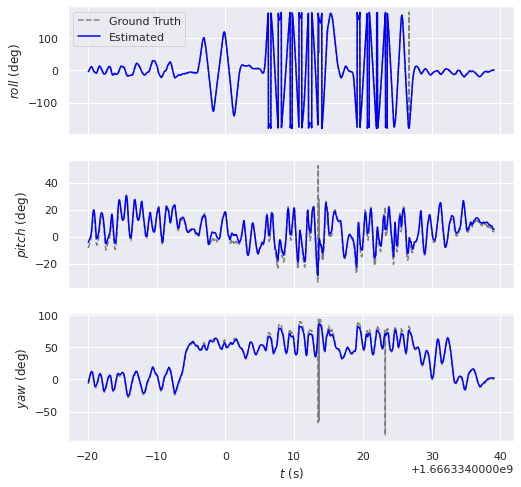

In [27]:
def plot_trajectory_rpy(pred_traj, gt_traj, title="", filename="", align=True, correct_scale=True, max_diff_sec=0.01):
    if align:
        try:
            pred_traj.align(gt_traj, correct_scale=correct_scale)
        except GeometryException as e:
            print("Plotting error:", e)
    
    # plot_collection = plot.PlotCollection("evo_traj - trajectory plot")
    fig_rpy, axarr_rpy = plt.subplots(3, sharex="col",figsize=(8, 8))
    plot.traj_rpy(axarr_rpy, gt_traj, '--', 'gray', "Ground Truth")
    plot.traj_rpy(axarr_rpy, pred_traj, '-', 'blue', "Estimated")
    # plt.savefig("../dataset/result.png")
    plt.show()

%matplotlib inline
plot_trajectory_rpy(evoEst, evoGT,f"# evaluated result is {res_str}")

In [23]:
def ate_rotation(traj_ref, tss_ref_us, traj_est, tstamps):
    # obtain the data structure of pose+timestamp
    evoGT = PoseTrajectory3D(
            positions_xyz=traj_ref[:,:3],
            orientations_quat_wxyz=traj_ref[:,3:], # EVO uses wxyz
            timestamps=(np.array(tss_ref_us)/1e6))
    
    # get the ground truth trajectory length
    gtlentraj = evoGT.get_infos()["path length (m)"]

    evoEst = PoseTrajectory3D(
            positions_xyz=traj_est[:,:3],#translation part
            orientations_quat_wxyz=traj_est[:,3:], # EVO uses wxyz
            timestamps=np.array(tstamps)/1e6)#change the unit from us to s
    
    # The metrics require the trajectories to be associated via matching timestamps:
    evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)

    # （absolute pose error ）
    ape_trans = main_ape.ape(evoGT, evoEst, pose_relation=metrics.PoseRelation.rotation_angle_deg, align=True, correct_scale=True)
    # get the rmse value，and then multiply 100 to get the cm
    evoATE = ape_trans.stats["mean"] #以度为单位的均值
    MRE = ape_trans.stats["mean"] / gtlentraj * 100 # mean pose error of our EVIO
    return evoATE, MRE, evoGT, evoEst

ate_score, MRE, evoGT, evoEst = ate_rotation(gt_poses, tss_gt_us, est_poses, tss_est_us)
res_str = f"\nATE / mean[\u00b0]: {ate_score:.03f} | MRE, mean rotation error,[\u00b0/m]: {MPE:.03f}"
print(res_str)




ATE / mean[°]: 4.927 | MRE, mean rotation error,[°/m]: 0.554
